In [1]:
# import Math library
import math
from IPython import display

# Importing matplotlib for better graphical visualization
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import seaborn as sns

# import numpy for numerical computing
import numpy as np
# import pandas for dataframe
import pandas as pd

import missingno as msno
from sklearn import metrics
from sklearn.preprocessing import scale, StandardScaler, normalize
from sklearn import preprocessing
from sklearn import decomposition

# import PCA 
from sklearn.decomposition import PCA
# import kmeans for clustering 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import pickle
from collections import Counter

# import python plot
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.1f}'.format

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

**Task 1 - data analysis**

**Data import and cleaning**

In [2]:
# loading online retail dataset dataset
data = pd.read_excel("/Users/ruchitha/Desktop/DataMining_Projects/Online-retail-Analysis/clean_data.xlsx")

In [3]:
# removing all not applicable columns
data = data.dropna() 

In [4]:
# calculating total cost of the product purchased
total_cost = data['Quantity'] * data['UnitPrice']

In [5]:
# Classifying the customers based on the amount spent
spend_label = []
for i in range(0,len(data),1):
    if data['total_cost'].iloc[i] < 10000:
        spend_label.append(1)
    elif data['total_cost'].iloc[i] > 50000:
        spend_label.append(3)
    else:
        spend_label.append(2)

In [6]:
# adding an additonal spent_label feature
data['spend_label'] = spend_label

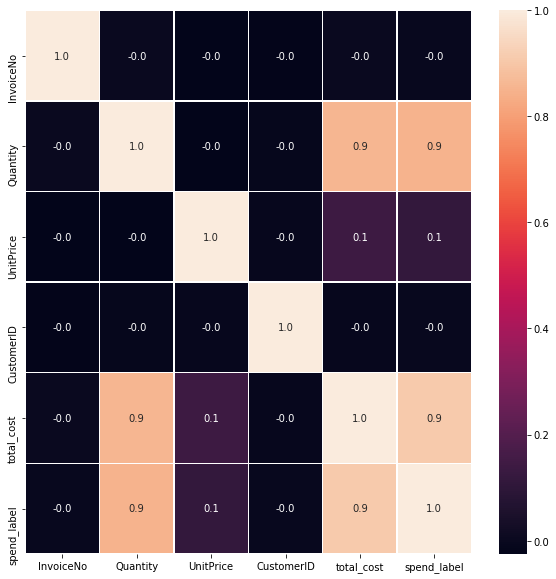

In [7]:
# heat map to look for correlation
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax);

The above table shows the correlation between the features under consideration

In [8]:
len(data.StockCode.unique()), len(data.Description.unique())

(3573, 3759)

In [9]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_cost,spend_label
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5,17850,United Kingdom,15.3,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.4,17850,United Kingdom,20.3,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.8,17850,United Kingdom,22.0,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.4,17850,United Kingdom,20.3,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.4,17850,United Kingdom,20.3,1


**Clustering : Group by customerID**

In [10]:
# Grouping customers by their ID
data_customer = data.groupby('CustomerID')
cluster_ds=pd.DataFrame(columns=['Quantity','UnitPrice', 'total_spend', 'CustomerID'])
count=0

In [11]:
# creating a dataset with just features which have high correlation values 
# as they can be used to make better predictions
for k,v in (data_customer):
    cluster_ds.loc[count] = [(v['Quantity'].sum()), v['UnitPrice'].sum(), v['total_cost'].sum(), k]
    count+=1

# Applying K-Means Clustering Algorithm to quantity, and total spend
X = cluster_ds.iloc[:, [0, 2]].values

In [12]:
cluster_ds.head()

,Quantity,UnitPrice,total_spend,CustomerID
0,74215.0,1.0,77183.6,12346.0
1,1590.0,346.9,2790.9,12347.0
2,2332.0,18.7,1437.2,12348.0
3,196.0,25.3,294.4,12350.0
4,401.0,267.3,1154.0,12352.0


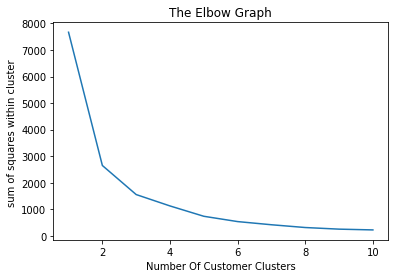

In [13]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X= sc_X.fit_transform(X)
# Elbow being used to identify the best k value
from sklearn.cluster import KMeans
#Within cluster sum of squares
sum_of_squares = []  
#Looping to get different set of clutsers
for i in range(1,11):  
    kmeans = KMeans(n_clusters = i, init ='k-means++',max_iter=300,n_init=10)
    kmeans.fit(X)
    sum_of_squares.append(kmeans.inertia_)
plt.plot(range(1,11) , sum_of_squares)
plt.title('The Elbow Graph')
plt.xlabel('Number Of Customer Clusters')
plt.ylabel('sum of squares within cluster ')
plt.show()

Cluster that has a small sum of squares is more compact than a cluster that has a large sum of squares. We can notice that the value is smallest for n =5 to 10

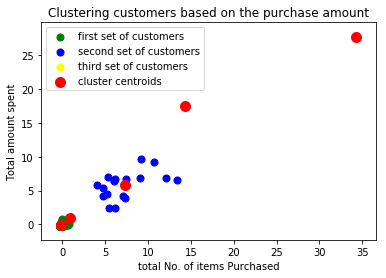

In [14]:
# Fitting K-Means to the dataset. Considering number of clusters to be 2
kmeans = KMeans(n_clusters = 5, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X)

# Visualising the clusters
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 50, c = 'green', label = 'first set of customers')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 50, c = 'blue', label = 'second set of customers')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 50, c = 'yellow', label = 'third set of customers')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'red', label = 'cluster centroids')
plt.title('Clustering customers based on the purchase amount')
plt.xlabel('total No. of items Purchased')
plt.ylabel('Total amount spent')
plt.legend()
plt.show()


For n=5, we can see from the scatter plot that there is a boundary sperating clusters mostly

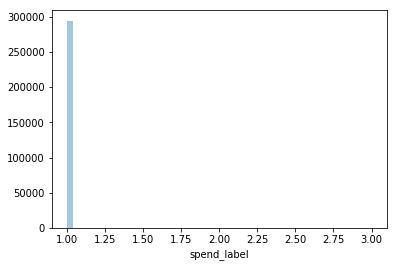

In [15]:
sns.distplot(data['spend_label'],kde = False)
plt.show()

From the above data we can notice that the data is quite imbalanced. so we make use of the transactions which involve lower values of the total amount spent by the customer to get rid of all outliers.

In [16]:
data_new = data[(data['total_cost'] >0) & (data['total_cost'] < 100)]

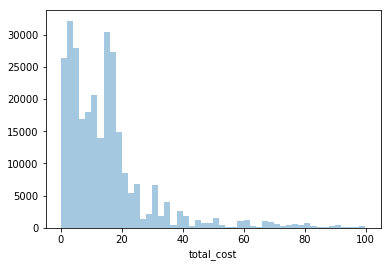

In [17]:
sns.distplot(data_new['total_cost'],kde = False)
plt.show()

From the above graph, we can notice that the total number of smaller amount purchases is more when compared to the ones made for higher amount.

Now we change the range that we are using for binning, to have the data more balanced.

In [18]:
spend_label = []
for i in range(0,len(data_new),1):
    if data_new['total_cost'].iloc[i] < 11:
        spend_label.append(0)
    elif data_new['total_cost'].iloc[i] >30:
        spend_label.append(2)
    else:
        spend_label.append(1)

In [19]:
data_new['spend_label'] = spend_label

In [20]:
data_new.shape # there is still a reasonably large sized data set to work with

(285380, 10)

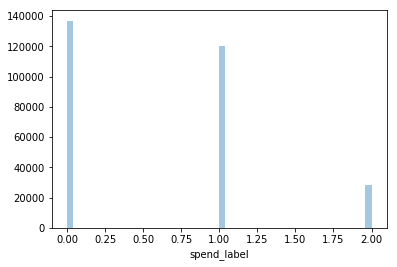

In [21]:
sns.distplot(data_new['spend_label'],kde = False)
plt.show()

The data is still unbalanced for high range values but better than the one we had earlier

**Create dummy variables from the string columns (descriptions and country)**

In [22]:
#  Creating dummies for description
dummy_1 = pd.get_dummies(data=data_new['Description'])
dummy_2 = pd.get_dummies(data=data_new['Country'])

In [23]:
new_ds = pd.concat([data_new, dummy_1, dummy_2], axis=1)
new_ds.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'total_cost', 'spend_label',
       ...
       'RSA', 'Saudi Arabia', 'Singapore', 'Spain', 'Sweden', 'Switzerland',
       'USA', 'United Arab Emirates', 'United Kingdom', 'Unspecified'],
      dtype='object', length=3792)

In [24]:
# drop the columns that are not required. Some are replaced by derived features 
unwanted_col = ['Quantity','StockCode','InvoiceDate','InvoiceNo','UnitPrice','Description','Country','CustomerID']
new_ds = new_ds.drop(unwanted_col, axis=1)

In [25]:
new_ds = new_ds.reset_index(drop=True)

In [26]:
# selecting the features for model training
new_ds_2 = new_ds.copy()
# deleting the target column from dataset
del new_ds_2['spend_label']
# Target column for training the model
ydata = new_ds['spend_label']

In [27]:
# normalizing the data before model training for better prdictions
normalized_data = preprocessing.normalize(new_ds_2)

In [28]:
new_ds_1 = pd.concat([data_new, dummy_1], axis=1)

In [29]:
new_ds_1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_cost,spend_label,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,TRELLIS COAT RACK,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 PINK ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,15 PINK FLUFFY CHICKS IN BOX,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PC CUTLERY SET PANTRY DESIGN,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,2 DAISIES HAIR COMB,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,2 PICTURE BOOK EGGS EASTER DUCKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,...,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP SUMMER ROSE DESIGN,WRAP VINTAGE LEAF DESIGN,WRAP VINTAGE PETALS DESIGN,WRAP WEDDING DAY,"WRAP, BILLBOARD FONTS DESIGN","WRAP, CAROUSEL",YELLOW BREAKFAST CUP AND SAUCER,YELLOW COAT RACK PARIS FASHION,YELLOW DRAGONFLY HELICOPTER,YELLOW EASTER EGG HUNT START POST,YELLOW FELT HANGING HEART W FLOWER,YELLOW FLOWERS FELT HANDBAG KIT,YELLOW GIANT GARDEN THERMOMETER,YELLOW METAL CHICKEN HEART,YELLOW PINK FLOWER DESIGN BIG BOWL,YELLOW POT PLANT CANDLE,YELLOW SHARK HELICOPTER,YELLOW/BLUE RETRO RADIO,YELLOW/ORANGE FLOWER DESIGN PLATE,YELLOW/PINK FLOWER DESIGN BIG MUG,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,YULETIDE IMAGES S/6 PAPER BOXES,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FINISH 15CM PLANTER POTS,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC HEARTS PLANT POT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC PLANT POT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5,17850,United Kingdom,15.3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.4,17850,United Kingdom,20.3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.8,17850,United Kingdom,22.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.4,17850,United Kingdom,20.3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.4,17850,United Kingdom,20.3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [30]:
# drop the columns that have been now been replaced  by derived features 
unwanted_cols = ['Quantity','StockCode','InvoiceDate','InvoiceNo','UnitPrice','Description','spend_label','CustomerID']
new_ds_1 = new_ds_1.drop(unwanted_cols, axis=1)

In [31]:
new_ds_1 = new_ds_1.reset_index(drop=True)

In [32]:
# selecting the features for model training
new_ds_3 = new_ds_1.copy()
# deleting the target colum from features set
del new_ds_3['Country']
# taget for training model
ydata2 = new_ds_1['Country']

In [33]:
# convert ydata2 to integer
ydata2 = ydata2.astype('category')

In [34]:
normalized_data2 = preprocessing.normalize(new_ds_3)

**Machine learning - predicting customer spend**

In [35]:
# Libraries of model to make predictions and to validate the models working
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,accuracy_score, f1_score
from sklearn.model_selection import  cross_val_score
from sklearn.externals import joblib 

In [36]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(normalized_data,ydata,test_size = 0.3, random_state = 8418) #70/30 training/test split - standard

In [37]:
import itertools

# confusion matrix plotting function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    else:
        1

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Naive Bayes**

In [38]:
from sklearn.naive_bayes import GaussianNB 
# creating a model instance
nb_model = GaussianNB() 
#fit the model to the data
nb_model.fit(xtrain, ytrain) 

GaussianNB(priors=None)

In [39]:
# Use the trained model to predict on the test data
predictions = list(nb_model.predict(xtest))
accuracy = accuracy_score(ytest, predictions)
# Model perfomance measurement
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Recall:', recall_score(ytest, predictions,average="micro")*100,"%")
print('Precision:', precision_score(ytest, predictions,average="micro")*100,"%")

Accuracy: 61.69%
Recall: 61.69201298852991 %
Precision: 61.69201298852991 %


We can notice from the above values that there is scope for further improvement as model does not work as intended to a good extent.

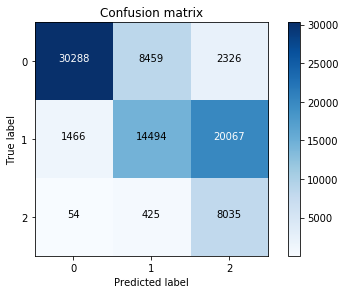

In [40]:
dat = confusion_matrix(ytest, predictions)

plot_confusion_matrix(
    dat, classes=[0,1,2], title='Confusion matrix')
plt.show()

**GradientBoost: LightGBM**

In [45]:
#predicting on test set
ypred=model.predict(xtest)

In [46]:
# convert the array of probabilities for each class output by LightGBM into a single list 
# containing the class with the highest probability.

predictions = []
#predicting on test set
for x in ypred:
    predictions.append(np.argmax(x))

In [47]:
# predicting model perfomance
accuracy = accuracy_score(ytest, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Recall:', recall_score(ytest, predictions,average="micro")*100,"%")
print('Precision:', precision_score(ytest, predictions,average="micro")*100,"%")

Accuracy: 99.99%
Recall: 99.99415983367206 %
Precision: 99.99415983367206 %


We can see that this model prediction capability is good

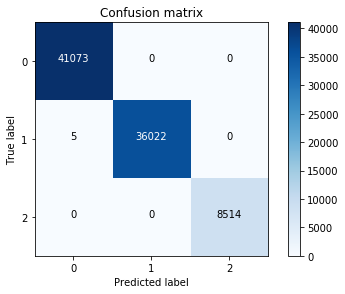

In [48]:
dat = confusion_matrix(ytest, predictions)

plot_confusion_matrix(
    dat, classes=[0,1,2], title='Confusion matrix')
plt.show()

** Random Forest Classifier **

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(n_estimators=20, max_depth=2,random_state=0)
clf.fit(xtrain, ytrain) 
#predicting on test set
predictions = clf.predict(xtest)
accuracy = accuracy_score(ytest, predictions)
# predicting model perfomance
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Recall:', recall_score(ytest, predictions,average="micro")*100,"%")
print('Precision:', precision_score(ytest, predictions,average="micro")*100,"%")

Accuracy: 90.06%
Recall: 90.05536477678884 %
Precision: 90.05536477678884 %


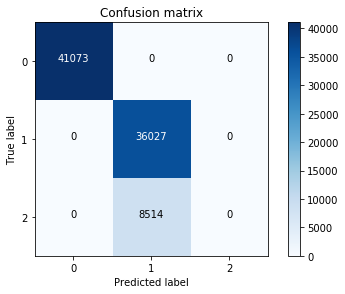

In [52]:
dat = confusion_matrix(ytest, predictions)

plot_confusion_matrix(
    dat, classes=[0,1,2], title='Confusion matrix')
plt.show()

** Multiple Perceptron Classifier (Deep Learning model) **

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(20, 2), random_state=1)
clf.fit(xtrain, ytrain) 
#predicting on test set
predictions = clf.predict(xtest)
accuracy = accuracy_score(ytest, predictions)

In [55]:
# predicting model perfomance
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Recall:', recall_score(ytest, predictions,average="micro")*100,"%")
print('Precision:', precision_score(ytest, predictions,average="micro")*100,"%")

Accuracy: 87.77%
Recall: 87.76952367603428 %
Precision: 87.76952367603428 %


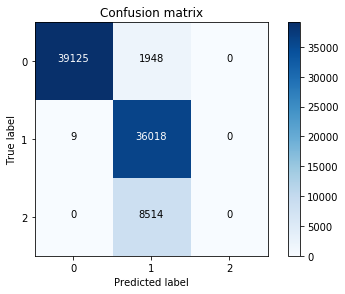

In [56]:
dat = confusion_matrix(ytest, predictions)

plot_confusion_matrix(
    dat, classes=[0,1,2], title='Confusion matrix')
plt.show()

**  Adaboost classifier **

In [59]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=1, random_state=0)
clf.fit(xtrain, ytrain) 
#predicting on test set
predictions = clf.predict(xtest)
accuracy = accuracy_score(ytest, predictions)
# model perfomance scores
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Recall:', recall_score(ytest, predictions,average="micro")*100,"%")
print('Precision:', precision_score(ytest, predictions,average="micro")*100,"%")

Accuracy: 100.00%
Recall: 100.0 %
Precision: 100.0 %


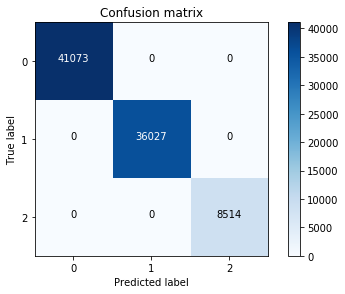

In [60]:
dat = confusion_matrix(ytest, predictions)

plot_confusion_matrix(
    dat, classes=[0,1,2], title='Confusion matrix')
plt.show()

**Machine learning - predicting country of origin**

In [61]:
xtrain, xtest, ytrain, ytest = train_test_split(normalized_data2,ydata2,test_size = 0.3, random_state = 8418) #70/30 training/test split - standard

In [62]:
nb_model2 = GaussianNB() #instantiate the model - done (GaussianNB has no hyperparameters)
nb_model2.fit(xtrain, ytrain) #fit the model to the data

GaussianNB(priors=None)

In [63]:
# Use the trained model to predict on the test data
predictions = list(nb_model2.predict(xtest))

In [64]:
accuracy = accuracy_score(ytest, predictions)
# model perfomance scores
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print('Recall:', recall_score(ytest, predictions,average="micro")*100)
print('Precision:', precision_score(ytest, predictions,average="micro")*100)

Accuracy: 7.66%
Recall: 7.663466255518957
Precision: 7.663466255518957


**Random Forest Classifier**

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(n_estimators=20, max_depth=2,random_state=0)
clf.fit(xtrain, ytrain) 
#predicting on test set
predictions = clf.predict(xtest)
accuracy = accuracy_score(ytest, predictions)
# model perfomance scores
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Recall:', recall_score(ytest, predictions,average="micro")*100,"%")
print('Precision:', precision_score(ytest, predictions,average="micro")*100,"%")

Accuracy: 89.17%
Recall: 89.17233162800477 %
Precision: 89.17233162800477 %


** Multiple Perceptron Classifier (Deep Learning model)  **

In [67]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(20, 2), random_state=1)
clf.fit(xtrain, ytrain) 
#predicting on test set
predictions = clf.predict(xtest)
accuracy = accuracy_score(ytest, predictions)
# model perfomance scores
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Recall:', recall_score(ytest, predictions,average="micro")*100,"%")
print('Precision:', precision_score(ytest, predictions,average="micro")*100,"%")

Accuracy: 89.17%
Recall: 89.17233162800477 %
Precision: 89.17233162800477 %
